In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

from solution import *

## Part 1: Heat exchange simulation

### Manual test

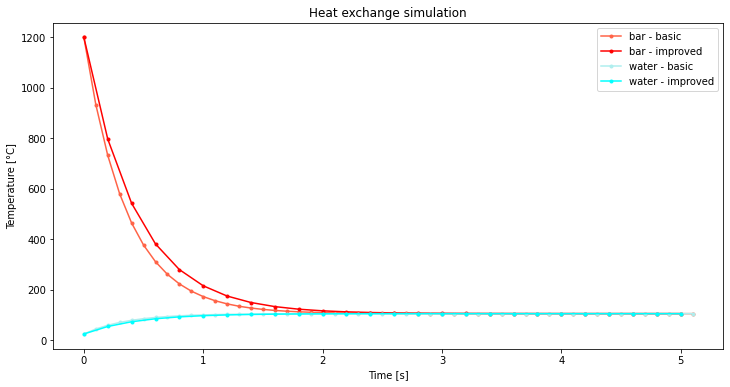

In [2]:
SIM_TIME = 5.0
TIME_STEP = 0.1
SETTINGS = dict(Tb=1200.0, Tw=25.0, mb=0.2, mw=2.5, cb=3.85, cw=4.1813, h=160, a=0.0109)

# run simulations
sim_basic = HeatExchangeSimulation(**SETTINGS, improved=False)
sim_basic.simulate_until(SIM_TIME, dt=TIME_STEP)

sim_improved = HeatExchangeSimulation(**SETTINGS, improved=True)
sim_improved.simulate_until(SIM_TIME, dt=TIME_STEP*2)

# plot
plt.figure(figsize=(12,6))

plt.plot(sim_basic.t_history, sim_basic.Tb_history, color='tomato', marker='o', markersize=3, label='bar - basic')
plt.plot(sim_improved.t_history, sim_improved.Tb_history, color='red', marker='o', markersize=3, label='bar - improved')
plt.plot(sim_basic.t_history, sim_basic.Tw_history, color='paleturquoise', marker='o', markersize=3, label='water - basic')
plt.plot(sim_improved.t_history, sim_improved.Tw_history, color='cyan', marker='o', markersize=3, label='water - improved')

plt.title('Heat exchange simulation')
plt.legend(loc='upper right')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]');

# plt.savefig('heat-exchange-plot-example.pdf')

### Ground truth test

In [3]:
ground_truth = pd.read_csv('data/ground-truth.csv', index_col=0).astype(float)
ground_truth

,Tb,Tw,mb,mw,cb,cw,h,a,t,Tbt,Twt
2,800.0,25.0,0.2,2.5,3.85,4.1813,160.0,0.0109,3.0,79.1,78.0
5,800.0,25.0,0.2,2.5,3.85,4.1813,160.0,0.0109,5.0,78.2,78.1
6,1100.0,70.0,0.2,2.5,3.85,4.1813,160.0,0.0109,2.0,150.1,138.2
3,1100.0,70.0,0.2,2.5,3.85,4.1813,160.0,0.0109,3.0,142.1,139.1
9,1100.0,70.0,0.2,2.5,3.85,4.1813,160.0,0.0109,4.0,141.2,139.8
10,1100.0,70.0,0.2,2.5,3.85,4.1813,160.0,0.0109,5.0,140.9,140.1
7,1100.0,70.0,0.2,5.0,3.85,4.1813,160.0,0.0109,2.0,116.6,105.1
8,1100.0,70.0,0.2,10.0,3.85,4.1813,160.0,0.0109,2.0,99.1,88.1
1,1200.0,25.0,0.2,2.5,3.85,4.1813,160.0,0.0109,3.0,107.7,105.1
4,1200.0,25.0,0.2,2.5,3.85,4.1813,160.0,0.0109,5.0,105.7,105.5


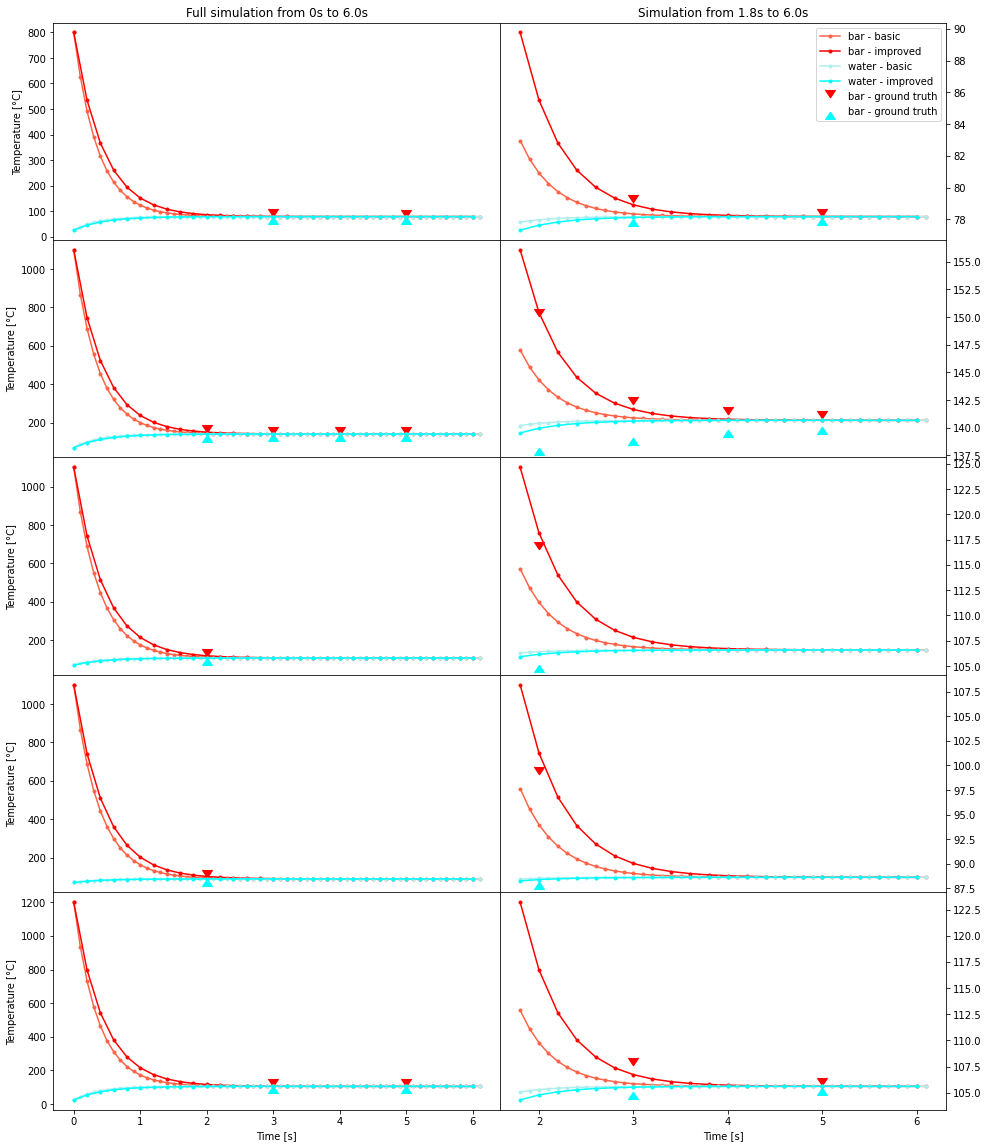

In [4]:
SIM_FROM = 1.8
SIM_TO = 6.0
TIME_STEP = 0.1

skip = int(SIM_FROM / TIME_STEP)
steps = int(SIM_TO / TIME_STEP)

# group ground truth into experiments
settings_columns = list(ground_truth.columns[:-3])
experiments = ground_truth.groupby(settings_columns)

# setup plot
fig = plt.figure(figsize=(16,4*len(experiments)))
gs = gridspec.GridSpec(len(experiments), 2, hspace=0, wspace=0) 

# for each experiment
for i, (settings_values, gt) in enumerate(experiments):
    settings = dict(zip(settings_columns, settings_values))
    
    # run simulations
    sim_basic = HeatExchangeSimulation(**settings, improved=False)
    sim_basic.simulate_until(SIM_TO, dt=TIME_STEP)

    sim_improved = HeatExchangeSimulation(**settings, improved=True)
    sim_improved.simulate_until(SIM_TO, dt=TIME_STEP*2)
    
    # plot
    ax0 = plt.subplot(gs[i,0])
    ax1 = plt.subplot(gs[i,1])
    
    
    ax0.plot(sim_basic.t_history, sim_basic.Tb_history, color='tomato', marker='o', markersize=3, label='bar - basic')
    ax0.plot(sim_improved.t_history, sim_improved.Tb_history, color='red', marker='o', markersize=3, label='bar - improved')
    ax0.scatter(gt['t'], gt['Tbt'], c='red', marker=7, s=100, label='bar - ground truth')
    ax0.plot(sim_basic.t_history, sim_basic.Tw_history, color='paleturquoise', marker='o', markersize=3, label='water - basic')
    ax0.plot(sim_improved.t_history, sim_improved.Tw_history, color='cyan', marker='o', markersize=3, label='water - improved')
    ax0.scatter(gt['t'], gt['Twt'], c='cyan', marker=6, s=100, label='bar - ground truth')
    
    
    ax1.plot(sim_basic.t_history[skip:], sim_basic.Tb_history[skip:], color='tomato', marker='o', markersize=3, label='bar - basic')
    ax1.plot(sim_improved.t_history[skip//2:], sim_improved.Tb_history[skip//2:], color='red', marker='o', markersize=3, label='bar - improved')
    ax1.scatter(gt['t'], gt['Tbt'], c='red', marker=7, s=100, label='bar - ground truth')
    ax1.plot(sim_basic.t_history[skip:], sim_basic.Tw_history[skip:], color='paleturquoise', marker='o', markersize=3, label='water - basic')
    ax1.plot(sim_improved.t_history[skip//2:], sim_improved.Tw_history[skip//2:], color='cyan', marker='o', markersize=3, label='water - improved')
    ax1.scatter(gt['t'], gt['Twt'], c='cyan', marker=6, s=100, label='bar - ground truth')
    
    ax1.yaxis.tick_right()
    ax0.set_xlabel('Time [s]')
    ax1.set_xlabel('Time [s]')
    ax0.set_ylabel('Temperature [°C]')
    
    if i == 0:
        ax0.set_title(f'Full simulation from 0s to {SIM_TO}s')
        ax1.set_title(f'Simulation from {SIM_FROM}s to {SIM_TO}s')
        ax1.legend(loc='upper right')

# plt.savefig('heat-exchange-simulations.pdf')

In [5]:
TIME_STEP = 0.1

results = ground_truth[['Tbt', 'Twt']].add_suffix('_gt')
results['Tbt_basic'] = None
results['Twt_basic'] = None
results['Tbt_improved'] = None
results['Twt_improved'] = None

# gather simulation results
for index, row in ground_truth.iterrows():
    settings = row[:-3].to_dict()
    
    # run simulations
    sim_basic = HeatExchangeSimulation(**settings, improved=False)
    sim_basic.simulate_until(row['t'], dt=TIME_STEP)

    sim_improved = HeatExchangeSimulation(**settings, improved=True)
    sim_improved.simulate_until(row['t'], dt=TIME_STEP*2)
    
    # save results
    results.at[index, ['Tbt_basic', 'Twt_basic']] = [sim_basic.Tb, sim_basic.Tw]
    results.at[index, ['Tbt_improved', 'Twt_improved']] = [sim_improved.Tb, sim_improved.Tw]

# calcualte errors
results['Tbt_basic_error'] = (results['Tbt_basic'] - results['Tbt_gt']).abs()
results['Tbt_improved_error'] = (results['Tbt_improved'] - results['Tbt_gt']).abs()
results['Twt_basic_error'] = (results['Twt_basic'] - results['Twt_gt']).abs()
results['Twt_improved_error'] = (results['Twt_improved'] - results['Twt_gt']).abs()


# rearange columns
results = results[['Tbt_gt', 'Tbt_basic', 'Tbt_basic_error', 'Tbt_improved', 'Tbt_improved_error', 'Twt_gt', 'Twt_basic', 'Twt_basic_error', 'Twt_improved', 'Twt_improved_error']]

# round values for printing
results = results.astype(float).round({'Tbt_gt': 1, 'Tbt_basic': 2, 'Tbt_basic_error': 4, 'Tbt_improved': 2, 'Tbt_improved_error': 4, 'Twt_gt': 1, 'Twt_basic': 2, 'Twt_basic_error': 4, 'Twt_improved': 2, 'Twt_improved_error': 4})

#print(results.to_latex())
results

,Tbt_gt,Tbt_basic,Tbt_basic_error,Tbt_improved,Tbt_improved_error,Twt_gt,Twt_basic,Twt_basic_error,Twt_improved,Twt_improved_error
2,79.1,78.34,0.7600,78.91,0.1907,78.0,78.16,0.1584,78.12,0.1165
5,78.2,78.17,0.0286,78.18,0.0216,78.1,78.17,0.0708,78.17,0.0703
6,150.1,144.31,5.7879,146.82,3.2793,138.2,140.40,2.1972,140.21,2.0124
3,142.1,140.89,1.2094,141.65,0.4528,139.1,140.65,1.5492,140.59,1.4935
9,141.2,140.68,0.5203,140.76,0.4353,139.8,140.66,0.8648,140.66,0.8585
10,140.9,140.67,0.2335,140.68,0.2242,140.1,140.67,0.5658,140.67,0.5651
7,116.6,111.29,5.3106,114.00,2.6028,105.1,106.41,1.3149,106.32,1.2151
8,99.1,93.96,5.1390,96.77,2.3340,88.1,88.53,0.4265,88.47,0.3749
1,107.7,105.87,1.8297,106.73,0.9665,105.1,105.60,0.4950,105.53,0.4314
4,105.7,105.61,0.0854,105.63,0.0747,105.5,105.61,0.1138,105.61,0.1131


## Part 2: Approximation and interpolation

### Groud truth data

In [6]:
conductivity_data = pd.read_csv('data/conductivity.csv').astype(float)

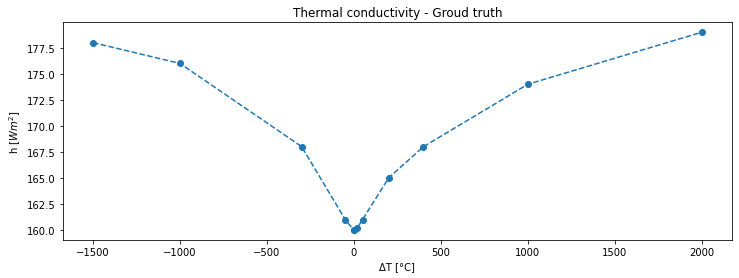

In [7]:
plt.figure(figsize=(12,4))
plt.plot(conductivity_data.dT, conductivity_data.h, 'o--')
plt.xlabel('ΔT [°C]')
plt.ylabel('h [$Wm^2$]')
plt.title('Thermal conductivity - Groud truth');

### Normalization

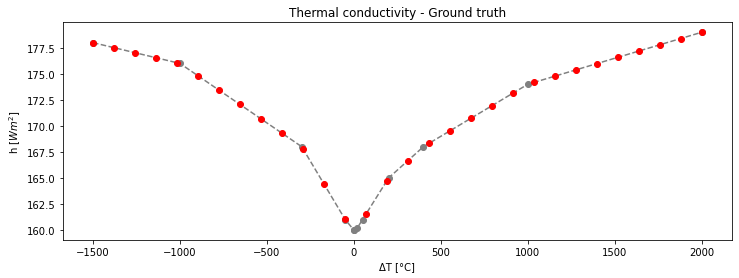

In [8]:
conductivity_chain = LinearSpline(conductivity_data.values)
conductivity_norm = tabularize(conductivity_chain, -1500, 2000, 30)

plt.figure(figsize=(12,4))
plt.plot(conductivity_data.dT, conductivity_data.h, 'o--', c='grey')
plt.scatter(conductivity_norm[:,0], conductivity_norm[:,1], c='r', zorder=10)
plt.xlabel('ΔT [°C]')
plt.ylabel('h [$Wm^2$]')
plt.title('Thermal conductivity - Ground truth');

### Approximation params searching

In [9]:
DEGREES = list(range(1, 5))
SAMPLES = [None] + list(range(5, 31, 5))

conductivity_chain = LinearSpline(conductivity_data.values)

results = []
for degree, samples in itertools.product(DEGREES, SAMPLES):
    
    # prepare samples
    if not samples:
        data = conductivity_data.values
    else:
        data = tabularize(conductivity_chain, -1500, 2000, samples)
    
    # calculate approximation error
    approx = PolynomialApproximation(data, degree)
    error = approximation_error(approx, conductivity_data.values)
    
    results.append((degree, samples, error))

# display results
results = pd.DataFrame.from_records(results, columns=['degree', 'samples', 'error'])
results.sort_values('error').head(15)

,degree,samples,error
21,4,NaN,2.106263
14,3,NaN,3.401203
24,4,15.0,3.457066
23,4,10.0,3.486933
25,4,20.0,3.528836
26,4,25.0,3.554785
27,4,30.0,3.561581
22,4,5.0,3.617229
7,2,NaN,3.674151
17,3,15.0,4.743237


### Approximation results

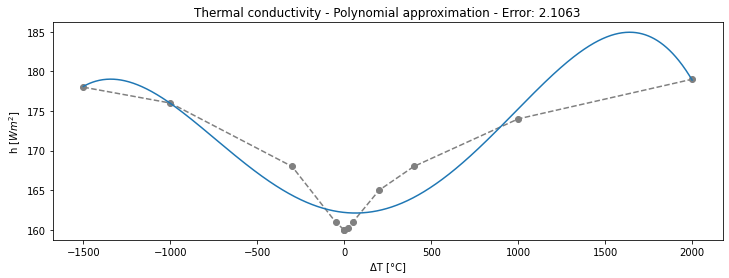

In [10]:
DEGREE = 4
SAMPLES = None

# prepare samples
if not SAMPLES:
    samples = conductivity_data.values
else:
    conductivity_chain = LinearSpline(conductivity_data.values)
    samples = tabularize(conductivity_chain, -1500, 2000, SAMPLES)

# create approximation
approx = PolynomialApproximation(samples, DEGREE)

# prepare data
data = tabularize(approx, -1500, 2000, 1000)
error = approximation_error(approx, conductivity_data.values)

# plot
plt.figure(figsize=(12,4))
plt.plot(conductivity_data.dT, conductivity_data.h, 'o--', c='grey')
plt.plot(data[:,0], data[:,1])
plt.xlabel('ΔT [°C]')
plt.ylabel('h [$Wm^2$]')
plt.title(f'Thermal conductivity - Polynomial approximation - Error: {error:.5}');

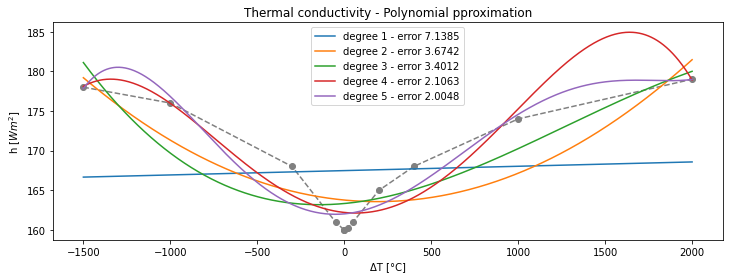

In [11]:
DEGREES = [1,2,3,4,5]

# setup plot
plt.figure(figsize=(12,4))
plt.plot(conductivity_data.dT, conductivity_data.h, 'o--', c='grey')
plt.xlabel('ΔT [°C]')
plt.ylabel('h [$Wm^2$]')
plt.title('Thermal conductivity - Polynomial pproximation');

for degree in DEGREES:
    # create approximation
    approx = PolynomialApproximation(conductivity_data.values, degree)

    # prepare data
    data = tabularize(approx, -1500, 2000, 1000)
    error = approximation_error(approx, conductivity_data.values)

    # plot
    plt.plot(data[:,0], data[:,1], label=f'degree {degree} - error {error:.5}')

plt.legend()

### Spline interpolation results

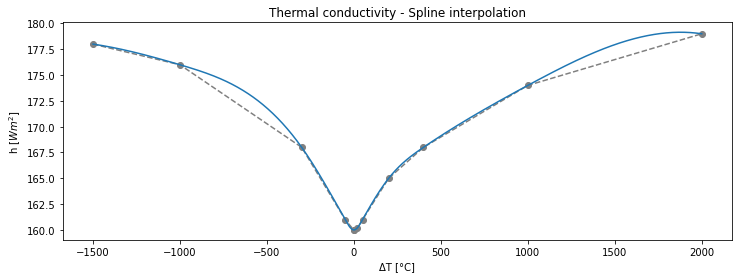

In [12]:
SAMPLES = None

# prepare samples
if not SAMPLES:
    samples = conductivity_data.values
else:
    conductivity_chain = LinearSpline(conductivity_data.values)
    samples = tabularize(conductivity_chain, -1500, 2000, SAMPLES)

# crate spline
spline = CubicSpline(samples)
data = tabularize(spline, -1500, 2000, 1000)

# plot
plt.figure(figsize=(12,4))
plt.plot(conductivity_data.dT, conductivity_data.h, 'o--', c='grey')
plt.plot(data[:,0], data[:,1])
plt.xlabel('ΔT [°C]')
plt.ylabel('h [$Wm^2$]')
plt.title('Thermal conductivity - Spline interpolation');

### Functions difference

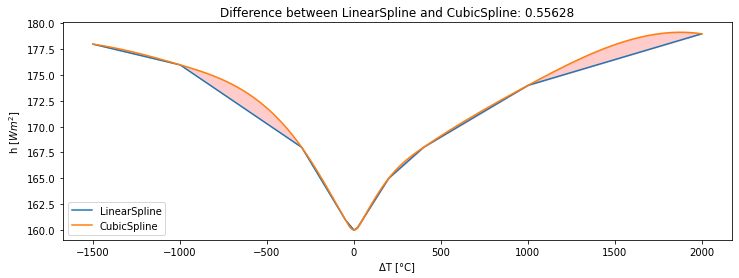

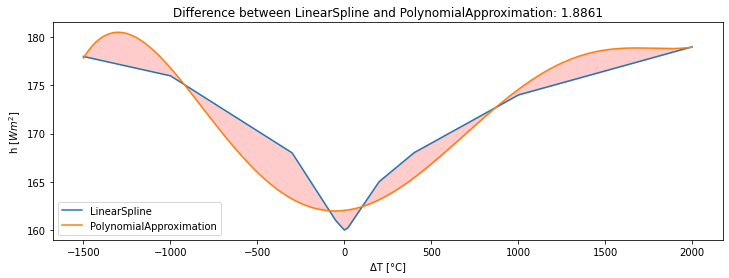

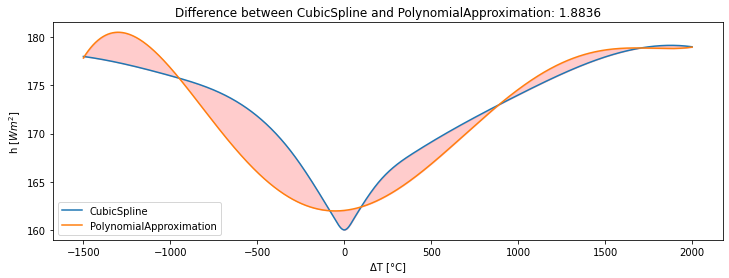

In [13]:
f_linear = LinearSpline(conductivity_data.values)
f_spline = CubicSpline(conductivity_data.values)
f_approx = PolynomialApproximation(conductivity_data.values, degree=5)

funcs = [f_linear, f_spline, f_approx]

for f, g in itertools.combinations(funcs, 2):
    avg_diff = functions_difference(f, g, -1500, 2000, 100)
    f_data = tabularize(f, -1500, 2000, 1000)
    g_data = tabularize(g, -1500, 2000, 1000)
    
    plt.figure(figsize=(12,4))
    plt.fill_between(f_data[:,0], f_data[:, 1], g_data[:, 1], alpha=0.2, color='red')
    plt.plot(f_data[:,0], f_data[:,1], label=type(f).__name__)
    plt.plot(g_data[:,0], g_data[:,1], label=type(g).__name__)
    plt.xlabel('ΔT [°C]')
    plt.ylabel('h [$Wm^2$]')
    plt.legend()
    plt.title(f'Difference between {type(f).__name__} and {type(g).__name__}: {avg_diff:.5}');
    
    # plt.savefig(f'diff-{type(f).__name__}-{type(g).__name__}.pdf')
    plt.show()
    

## Heat exchange simulation v2 - dynamic h

In [14]:
h = CubicSpline(conductivity_data.values)

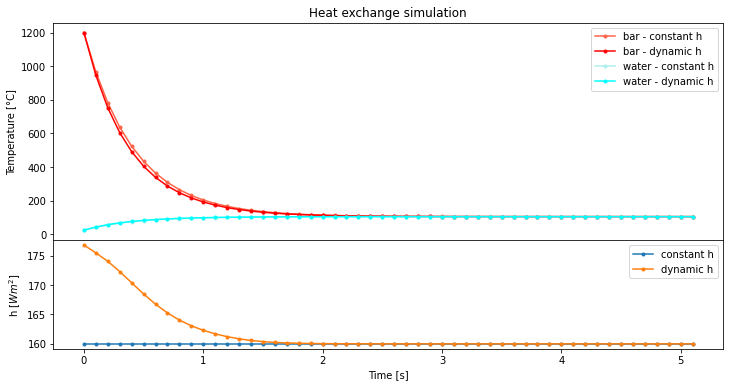

In [15]:
SIM_TIME = 5.0
TIME_STEP = 0.1
CONSTANT_H = 160
DYNAMIC_H = CubicSpline(conductivity_data.values)
SETTINGS = dict(Tb=1200.0, Tw=25.0, mb=0.2, mw=2.5, cb=3.85, cw=4.1813, a=0.0109)

# run simulations
sim_constant = HeatExchangeSimulation(**SETTINGS, h=CONSTANT_H)
sim_constant.simulate_until(SIM_TIME, dt=TIME_STEP)

sim_dynamic = HeatExchangeSimulation(**SETTINGS, h=DYNAMIC_H)
sim_dynamic.simulate_until(SIM_TIME, dt=TIME_STEP)

# plot
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.plot(sim_constant.t_history, sim_constant.Tb_history, color='tomato', marker='o', markersize=3, label='bar - constant h')
ax0.plot(sim_dynamic.t_history, sim_dynamic.Tb_history, color='red', marker='o', markersize=3, label='bar - dynamic h')
ax0.plot(sim_constant.t_history, sim_constant.Tw_history, color='paleturquoise', marker='o', markersize=3, label='water - constant h')
ax0.plot(sim_dynamic.t_history, sim_dynamic.Tw_history, color='cyan', marker='o', markersize=3, label='water - dynamic h')

ax0.set_title('Heat exchange simulation')
ax0.legend(loc='upper right')
ax0.set_ylabel('Temperature [°C]');
ax0.axes.xaxis.set_visible(False)


ax1.plot(sim_constant.t_history, sim_constant.h_history, marker='o', markersize=3, label='constant h')
ax1.plot(sim_dynamic.t_history, sim_dynamic.h_history, marker='o', markersize=3, label='dynamic h')
ax1.legend(loc='upper right')
ax1.set_ylabel('h [$Wm^2$]')
ax1.set_xlabel('Time [s]');

plt.savefig('heat-exchange-comparision.pdf')

In [26]:
TIME_STEP = 0.1
DYNAMIC_H = CubicSpline(conductivity_data.values)

results = ground_truth[['Tbt', 'Twt']].add_suffix('_gt')
results['Tbt_constant'] = None
results['Twt_constant'] = None
results['Tbt_dynamic'] = None
results['Twt_dynamic'] = None

# gather simulation results
for index, row in ground_truth.iterrows():
    settings = row[:-3].to_dict()
    del settings['h']
    
    # run simulations
    sim_constant = HeatExchangeSimulation(**settings, h=row['h'])
    sim_constant.simulate_until(row['t'], dt=TIME_STEP)

    sim_dynamic = HeatExchangeSimulation(**settings, h=DYNAMIC_H)
    sim_dynamic.simulate_until(row['t'], dt=TIME_STEP)
    
    # save results
    results.at[index, ['Tbt_constant', 'Twt_constant']] = [sim_constant.Tb, sim_constant.Tw]
    results.at[index, ['Tbt_dynamic', 'Twt_dynamic']] = [sim_dynamic.Tb, sim_dynamic.Tw]

# calcualte errors
results['Tbt_constant_error'] = (results['Tbt_constant'] - results['Tbt_gt']).abs() / results['Tbt_gt']
results['Tbt_dynamic_error'] = (results['Tbt_dynamic'] - results['Tbt_gt']).abs() / results['Tbt_gt']
results['Twt_constant_error'] = (results['Twt_constant'] - results['Twt_gt']).abs() / results['Twt_gt']
results['Twt_dynamic_error'] = (results['Twt_dynamic'] - results['Twt_gt']).abs() / results['Twt_gt']

# round values for printing
#results = results.drop(columns=['Tbt_constant', 'Tbt_dynamic', 'Twt_constant', 'Twt_dynamic'])
#results = results.astype(float).round({'Tbt_gt': 1, 'Twt_gt': 1})
#print(results.to_latex())

results

,Tbt_gt,Twt_gt,Tbt_constant,Twt_constant,Tbt_dynamic,Twt_dynamic,Tbt_constant_error,Tbt_dynamic_error,Twt_constant_error,Twt_dynamic_error
2,79.1,78.0,78.7049,78.1315,78.6538,78.1353,0.0049947,0.00564065,0.00168634,0.00173459
5,78.2,78.1,78.1743,78.1706,78.174,78.1706,0.000328537,0.00033274,0.000904224,0.000904534
6,150.1,138.2,148.513,140.088,147.594,140.155,0.0105707,0.0166934,0.0136595,0.0141494
3,142.1,139.1,141.376,140.614,141.292,140.62,0.00509803,0.00568333,0.0108808,0.0109249
9,141.2,139.8,140.73,140.661,140.722,140.662,0.00332862,0.00338189,0.00615935,0.00616331
10,140.9,140.1,140.67,140.665,140.67,140.666,0.00162973,0.00163353,0.00403618,0.00403646
7,116.6,105.1,116.132,106.237,115.01,106.278,0.00401417,0.013635,0.0108135,0.0112066
8,99.1,88.1,99.1566,88.4309,97.9166,88.4537,0.000571394,0.0119416,0.00375546,0.00401467
1,107.7,105.1,106.424,105.554,106.32,105.562,0.0118516,0.0128105,0.00432219,0.00439457
4,105.7,105.5,105.619,105.614,105.618,105.614,0.000765253,0.000771538,0.00107602,0.00107649


## Part 3: Newton-Raphson method

In [17]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

from solution import *

In [18]:
h = CubicSpline(pd.read_csv('data/conductivity.csv').astype(float).values)

SETTINGS = dict(Tb=1200.0, Tw=25.0, mb=0.25, cb=0.29, cw=4.1813, h=h, a=0.0109)

SIM_DT = 0.01
SIM_TIME = 0.7
TARGET_TEMP = 125.0
INIT_MASS = 0.1
NR_STEP = 0.01
NR_SCALE = 0.01
NR_EPSILON = 1e-5

In [19]:
def Tb(mw, dt, t, settings):
    sim = HeatExchangeSimulation(mw = mw, **settings)
    sim.simulate_until(t, dt = dt)
    return sim.Tb

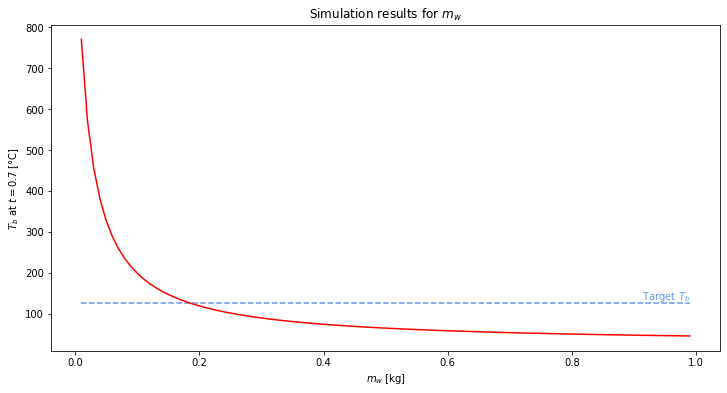

In [27]:
x = np.arange(0.01, 1.0, 0.01)
y = [Tb(mw, dt=SIM_DT, t=SIM_TIME, settings=SETTINGS) for mw in x]

plt.figure(figsize=(12,6))
plt.plot(x, y, c='red')
plt.hlines(TARGET_TEMP, x[0], x[-1], linestyles='dashed', colors='cornflowerblue')
plt.text(x[-1], TARGET_TEMP + 10, 'Target $T_b$', horizontalalignment='right', c='cornflowerblue')
plt.ylabel(f'$T_b$ at $t={SIM_TIME}$ [°C]')
plt.xlabel('$m_w$ [kg]')
plt.title('Simulation results for $m_w$');

plt.savefig('part3-simulation.pdf')

In [31]:
f = lambda x: Tb(x, dt=SIM_DT, t=SIM_TIME, settings=SETTINGS) - TARGET_TEMP

nr = NewtonRaphson(f = f, x0 = INIT_MASS, dx = NR_STEP, scale = NR_SCALE)
nr.run(NR_EPSILON)

print(nr.x, nr.y + TARGET_TEMP)

0.1863953911392946 125.00000660253701


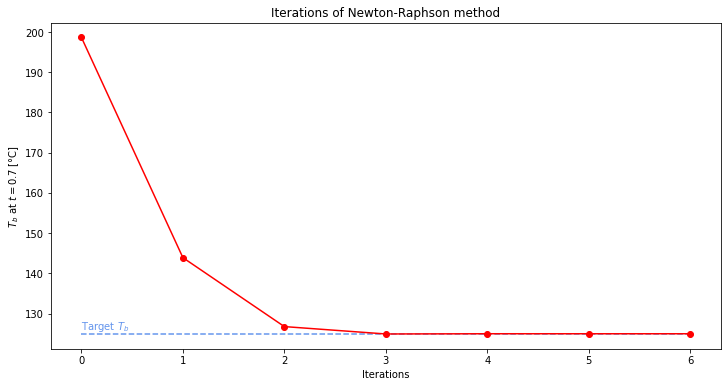

In [32]:
plt.figure(figsize=(12,6))
plt.hlines(TARGET_TEMP, 0, nr.history.shape[0]-1, linestyles='dashed', colors='cornflowerblue')
plt.text(0, TARGET_TEMP + 1, 'Target $T_b$', c='cornflowerblue')
plt.plot(nr.history[:,1] + TARGET_TEMP, 'o-', c='red')
plt.xticks(range(nr.history.shape[0]))
plt.ylabel(f'$T_b$ at $t={SIM_TIME}$ [°C]')
plt.xlabel('Iterations')
plt.title('Iterations of Newton-Raphson method');

plt.savefig('part3-newton-raphson.pdf')